In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('..')
from datetime import datetime, timedelta
import lightgbm as lgb
import joblib
import matplotlib.cm as cm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# META DATAPROCESS

In [4]:
meta_file = "data/metadata.csv"
df_meta = pd.read_csv(meta_file)

# feature_selected # check trong file metadata_process.ipynb
combo_features1 = ["electricity", "chilledwater", "hotwater"]

df_meta_selected = df_meta[df_meta[combo_features1].eq("Yes").all(axis=1)].reset_index()
# print(df_meta.columns)
# filter features
dataset_features = ['building_id', 'site_id','primaryspaceusage', 'sqm']
df_meta_selected = df_meta_selected[dataset_features]
print(df_meta_selected.isna().sum())
BUILDIING_SELECTED = df_meta_selected['building_id'].to_list()
print(BUILDIING_SELECTED)
# df_meta_selected

building_id           0
site_id               0
primaryspaceusage    14
sqm                   0
dtype: int64
['Fox_education_Delma', 'Fox_education_Ollie', 'Fox_lodging_Helen', 'Fox_lodging_Stephen', 'Fox_education_Andre', 'Fox_education_Yolande', 'Fox_retail_Manie', 'Fox_office_Essie', 'Fox_education_Nilda', 'Fox_education_Kim', 'Fox_assembly_Boyce', 'Fox_food_Francesco', 'Fox_education_Leota', 'Fox_education_Heriberto', 'Fox_education_Sterling', 'Fox_education_Elois', 'Fox_education_Geoffrey', 'Fox_education_Gayla', 'Fox_education_Gloria', 'Fox_office_Sheila', 'Fox_assembly_Emma', 'Fox_education_Wendell', 'Fox_lodging_Alana', 'Fox_lodging_Wallace', 'Fox_lodging_Isabell', 'Fox_public_Martin', 'Fox_health_Lorena', 'Fox_education_Claude', 'Fox_education_Jaclyn', 'Fox_education_Otilia', 'Fox_education_Eldon', 'Fox_lodging_Stephan', 'Fox_education_Long', 'Fox_education_Leona', 'Fox_education_Dominique', 'Fox_education_Theodore', 'Fox_education_Melinda', 'Fox_assembly_Audrey', 'Fox_educati

In [5]:
file = "data/electricity_cleaned.csv"
df_e = pd.read_csv(file)

# Filter data by building list (electricity_cleaned, chilledwater_cleaned, hot_water_cleaned)

In [6]:
threshold = 400 # nan
print("Threshold: ", threshold)  # số giá trị bị nan cả từng tòa nhà


file = "data/electricity_cleaned.csv"
df_e = pd.read_csv(file)
print(len(df_e))
# df_e.head()
df_e_selected = df_e[BUILDIING_SELECTED]
df_e_selected.head()
nan_count_e = df_e_selected.isna().sum().sort_values()
print("len BUILDIING_SELECTED: ", len(BUILDIING_SELECTED))
BUILDIING_SELECTED = nan_count_e[nan_count_e < threshold].index.tolist()
nan_count_e = nan_count_e[nan_count_e < threshold]
print("electricity => BUILDIING_SELECTED: ", len(BUILDIING_SELECTED))



file = "data/chilledwater_cleaned.csv"
df_chille_water = pd.read_csv(file)
print(len(df_chille_water))
# df_chille_water.head()
df_chille_water_selected = df_chille_water[BUILDIING_SELECTED]
df_chille_water_selected.head()
nan_count_chille_water = df_chille_water_selected.isna().sum().sort_values()
BUILDIING_SELECTED = nan_count_chille_water[nan_count_chille_water < threshold].index.tolist()
nan_count_chille_water = nan_count_chille_water[nan_count_chille_water < threshold]
print("chille => BUILDIING_SELECTED: ", len(BUILDIING_SELECTED))



file = "data/hotwater_cleaned.csv"
df_hot_water = pd.read_csv(file)
print(len(df_hot_water))
# hot_water.head()
hot_water_selected = df_hot_water[BUILDIING_SELECTED]
hot_water_selected.head()
nan_count_hot_water = hot_water_selected.isna().sum().sort_values()
BUILDIING_SELECTED = nan_count_hot_water[nan_count_hot_water < threshold].index.tolist()
nan_count_hot_water = nan_count_hot_water[nan_count_hot_water < threshold]
print("hot_water => BUILDIING_SELECTED: ", len(BUILDIING_SELECTED))

print("BUILDIING_SELECTED: ", len(BUILDIING_SELECTED))


Threshold:  400
17544
len BUILDIING_SELECTED:  164
electricity => BUILDIING_SELECTED:  100
17544
chille => BUILDIING_SELECTED:  94
17544
hot_water => BUILDIING_SELECTED:  87
BUILDIING_SELECTED:  87


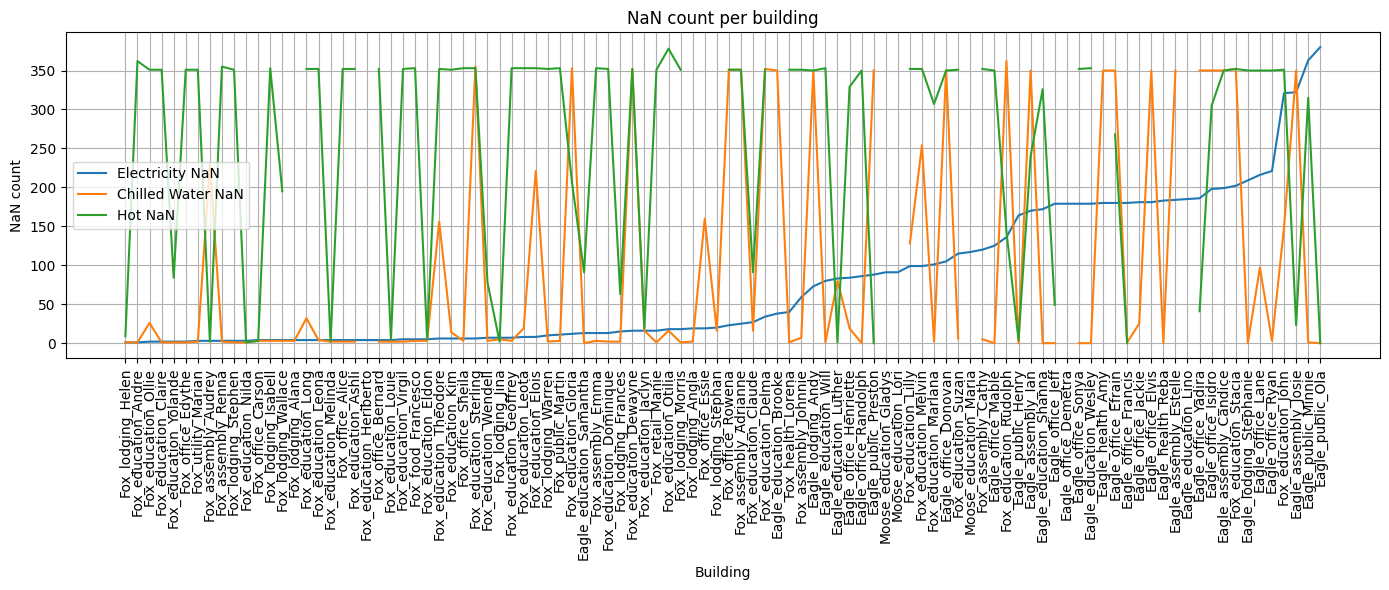

In [7]:
buildings = nan_count_e.index

nan_count_chille_water = nan_count_chille_water.reindex(buildings)
nan_count_hot_water = nan_count_hot_water.reindex(buildings)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(buildings, nan_count_e.values, label="Electricity NaN")
plt.plot(buildings, nan_count_chille_water.values, label="Chilled Water NaN")
plt.plot(buildings, nan_count_hot_water.values, label="Hot NaN")

plt.xlabel("Building")
plt.ylabel("NaN count")
plt.title("NaN count per building")
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)

plt.tight_layout()
plt.show()


# UPDATA data with BUILDIING_SELECTED

In [8]:
data_metadata_indexed = df_meta_selected[df_meta_selected["building_id"].isin(BUILDIING_SELECTED)].set_index('building_id')

df_e_selected = df_e[["timestamp"] + BUILDIING_SELECTED]
df_e_selected['timestamp'] = pd.to_datetime(df_e_selected['timestamp'])
df_e_selected.set_index('timestamp', inplace=True)

df_chille_water_selected = df_chille_water[["timestamp"] + BUILDIING_SELECTED]
df_chille_water_selected['timestamp'] = pd.to_datetime(df_chille_water_selected['timestamp'])
df_chille_water_selected.set_index('timestamp', inplace=True)

df_hot_water_selected = df_hot_water[["timestamp"] + BUILDIING_SELECTED]
df_hot_water_selected['timestamp'] = pd.to_datetime(df_hot_water_selected['timestamp'])
df_hot_water_selected.set_index('timestamp', inplace=True)


/var/folders/9j/40pxvw_12zl9rw6mldc3vvwr0000gn/T/ipykernel_14117/2544229758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e_selected['timestamp'] = pd.to_datetime(df_e_selected['timestamp'])
/var/folders/9j/40pxvw_12zl9rw6mldc3vvwr0000gn/T/ipykernel_14117/2544229758.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chille_water_selected['timestamp'] = pd.to_datetime(df_chille_water_selected['timestamp'])
/var/folders/9j/40pxvw_12zl9rw6mldc3vvwr0000gn/T/ipykernel_14117/2544229758.py:12: Setting

# Weather

In [9]:
df_weather = pd.read_csv('data/weather.csv')   # data giờ quét nhiều giá trị
df_weather["timestamp"] = pd.to_datetime(df_weather["timestamp"])
print(len(df_weather))
print(df_weather.columns)
# ktra so luong Nan ở các cột
count_na = df_weather.isna().sum()
# count_na
# df_w = df_w[['timestamp', 'airTemperature', 'dewTemperature', 'windSpeed']].dropna()
df_weather = df_weather[['timestamp','airTemperature', 'dewTemperature', 'windSpeed']].copy().set_index('timestamp')
df_weather.sort_values("timestamp")
df_weather.index.duplicated().sum()
df_weather_clean = (
    df_weather
    .groupby(level=0)
    .mean()      
)
print(len(df_weather_clean))
df_weather_clean

331166
Index(['timestamp', 'site_id', 'airTemperature', 'cloudCoverage',
       'dewTemperature', 'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure',
       'windDirection', 'windSpeed'],
      dtype='object')
17544


,airTemperature,dewTemperature,windSpeed
timestamp,,,
2016-01-01 00:00:00,4.070588,0.305882,2.476471
2016-01-01 01:00:00,4.305556,0.305556,2.211111
2016-01-01 02:00:00,3.655556,0.038889,1.533333
2016-01-01 03:00:00,3.477778,-0.294444,2.183333
2016-01-01 04:00:00,3.488889,-0.527778,2.383333
...,...,...,...
2017-12-31 19:00:00,1.912500,-3.356250,4.343750
2017-12-31 20:00:00,-0.515789,-5.852632,4.368421
2017-12-31 21:00:00,-1.078947,-6.126316,4.694737


In [10]:
# feature columns
X_cols = [
    "hour","dayofweek","is_weekend","month",
    # "lag_24","rolling_24",
    "electricity_current",
    "airTemperature", "dewTemperature", "windSpeed",
    # "temp_lag_1h","dewTemperature_lag_1h", "windSpeed_lag_1h",
    # "sqft", 
    "sqm", "primaryspaceusage", "site_id", "building_id",
    "Chilledwater", "Hotwater"
]

# PREPARE DATA FOR SITE: Cockatoo

In [11]:
# df_electric = df_model[['Cockatoo_lodging_Aimee']]
# df_merged = df_electric.join(df_weather_clean, how='left')
# df_merged.head()
# df_weather_clean

In [12]:
import os
import pandas as pd

save_data = "data_1578_csv"
os.makedirs(save_data, exist_ok=True)

list_building = [f for f in os.listdir(save_data)]
forecast_horizon = 24

for name_building in df_e_selected.columns:
    if name_building in list_building:
        print(f"{name_building} already processed, skipping...")
        continue

    try:
        site = name_building.split('_')[0]
        print(f"Processing building: {name_building} (site: {site})")

        # =========================
        # 1. LẤY ĐIỆN THEO BUILDING
        # =========================
        if name_building not in df_e_selected:
            print(f"No data for {name_building}, skipping...")
            continue

        df_electric_b_x = df_e_selected[[name_building]].rename(columns={name_building: "Electricity"})
        df_chilledwater = df_chille_water_selected[[name_building]].rename(columns={name_building: "Chilledwater"})
        df_hot_water = df_hot_water_selected[[name_building]].rename(columns={name_building: "Hotwater"})

        if df_electric_b_x is None or df_electric_b_x.empty:
            print(f"DataFrame is None or empty for {name_building}, skipping...")
            continue

        # =========================
        # 2. MERGE THỜI TIẾT
        # =========================
        df_train_test_x = df_electric_b_x.join(df_weather_clean, how='left')
        df_train_test_x = df_train_test_x.join(df_chilledwater, how="left")
        df_train_test_x = df_train_test_x.join(df_hot_water, how="left")
        
        if df_train_test_x.empty:
            print(f"Merged DataFrame is empty for {name_building}, skipping...")
            continue

        df_train_test_x.sort_index(inplace=True)

        # =========================
        # 3. FEATURE ENGINEERING
        # =========================
        df_train_test_x["hour"] = df_train_test_x.index.hour
        df_train_test_x["dayofweek"] = df_train_test_x.index.dayofweek
        df_train_test_x["is_weekend"] = (df_train_test_x["dayofweek"] >= 5).astype(int)
        df_train_test_x["month"] = df_train_test_x.index.month

        # df_train_test_x["electricity_current"] = df_train_test_x["Electricity"]
        # df_train_test_x["lag_24"] = df_train_test_x["Electricity"].shift(24)
        # df_train_test_x["rolling_24"] = df_train_test_x["Electricity"].rolling(24).mean()

        # df_train_test_x["temp_lag_1h"] = df_train_test_x["airTemperature"].shift(1)
        # df_train_test_x["dewTemperature_lag_1h"] = df_train_test_x["dewTemperature"].shift(1)
        # df_train_test_x["windSpeed_lag_1h"] = df_train_test_x["windSpeed"].shift(1)

        
        # =========================
        # 4. METADATA BUILDING
        # =========================
        if name_building not in data_metadata_indexed.index:
            print(f"No metadata for {name_building}, skipping...")
            continue

        meta = data_metadata_indexed.loc[name_building]

        # df_train_test_x["sqft"] = meta.get("sqft", 0)
        df_train_test_x["sqm"] = meta.get("sqm", 0)
        df_train_test_x["primaryspaceusage"] = meta.get("primaryspaceusage", "unknown")
        df_train_test_x["site_id"] = meta.get("site_id", "unknown")
        df_train_test_x["building_id"] = name_building

        # =========================
        # 5. DROP NA (SAU KHI TẠO FEATURE)
        # =========================
        df_train_test_x.dropna(inplace=True)
        if df_train_test_x.empty:
            print(f"All rows dropped due to NA for {name_building}, skipping...")
            continue

        # =========================
        # 6. TRAIN / TEST SPLIT
        # =========================
        cutoff = (df_train_test_x.index.max() - pd.DateOffset(months=4)).replace(hour=0)
        train_df_x = df_train_test_x[df_train_test_x.index < cutoff].copy()
        test_df_x  = df_train_test_x[df_train_test_x.index >= cutoff].copy()

        if train_df_x.empty:
            print(f"Train set is empty for {name_building}, skipping...")
            continue

        # =========================
        # 7. MULTI-HORIZON TARGET
        # =========================
        for h in range(forecast_horizon):
            col = f"target_t+{h+1}"
            train_df_x[col] = train_df_x["Electricity"].shift(-(h+1))
        train_df_x.dropna(inplace=True)

        if train_df_x.empty:
            print(f"Train set empty after shifting target for {name_building}, skipping...")
            continue

        # =========================
        # 8. SAVE CSV
        # =========================
        building_dir = os.path.join(save_data, name_building)
        os.makedirs(building_dir, exist_ok=True)

        train_df_x.to_csv(os.path.join(building_dir, "train.csv"))
        test_df_x.to_csv(os.path.join(building_dir, "test.csv"))

        print(f"{name_building} processed and saved ✅")
    
    except Exception as e:
        print(f"Error processing {name_building}: {e}")
        continue
    
    # break


Processing building: Eagle_public_Ola (site: Eagle)
Eagle_public_Ola processed and saved ✅
Processing building: Eagle_office_Francis (site: Eagle)
Eagle_office_Francis processed and saved ✅
Processing building: Eagle_public_Preston (site: Eagle)
Eagle_public_Preston processed and saved ✅
Processing building: Eagle_education_Luther (site: Eagle)
Eagle_education_Luther processed and saved ✅
Processing building: Fox_education_Nilda (site: Fox)
Fox_education_Nilda processed and saved ✅
Processing building: Fox_assembly_Audrey (site: Fox)
Fox_assembly_Audrey processed and saved ✅
Processing building: Fox_education_Melinda (site: Fox)
Fox_education_Melinda processed and saved ✅
Processing building: Fox_lodging_Jina (site: Fox)
Fox_lodging_Jina processed and saved ✅
Processing building: Fox_office_Carson (site: Fox)
Fox_office_Carson processed and saved ✅
Processing building: Eagle_public_Henry (site: Eagle)
Eagle_public_Henry processed and saved ✅
Processing building: Fox_education_Eldon (si